In [1]:
import os
import time
import datetime

import jax
import jax.numpy as jnp
import jax.random as jr
import equinox as eqx
import optax

import numpy as np 
import matplotlib.pyplot as plt
from chainconsumer import Chain, ChainConsumer, Truth
from tensorflow_probability.substrates.jax.distributions import Distribution

from configs import (
    cumulants_config, get_results_dir, get_posteriors_dir, 
    get_cumulants_sbi_args, get_ndes_from_config
)
from cumulants import (
    Dataset, get_data, get_prior, 
    get_compression_fn, get_datavector, get_linearised_data
)

from sbiax.utils import make_df, marker
from sbiax.ndes import Scaler, Ensemble, CNF, MAF 
from sbiax.train import train_ensemble
from sbiax.inference import nuts_sample

from affine import affine_sample
from utils import plot_moments, plot_latin_moments, plot_summaries, plot_fisher_summaries

/Users/Jed.Homer/phd/sbiaxpdf/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
t0 = time.time()

Finvs = []
for order_idx in [[0], [0, 1], [0, 1, 2]]:
    class Args:
        seed                = 0 #int(time.time())
        redshift            = 0.
        sbi_type            = "nle"
        linearised          = True
        reduced_cumulants   = True
        compression         = "linear"
        order_idx           = order_idx
        pre_train           = False and (not linearised)
        n_linear_sims       = 10_000
        verbose             = False
        use_tqdm            = True

    args = Args()

    print(args.order_idx)

    print("TIME:", datetime.datetime.now().strftime("%H:%M %d-%m-%y"))

    config = cumulants_config(
        seed=args.seed, 
        redshift=args.redshift, 
        reduced_cumulants=args.reduced_cumulants,
        sbi_type=args.sbi_type,
        linearised=args.linearised, 
        compression=args.compression,
        order_idx=args.order_idx,
        n_linear_sims=args.n_linear_sims,
        pre_train=args.pre_train
    )

    key = jr.key(config.seed)

    ( 
        model_key, train_key, key_prior, 
        key_datavector, key_state, key_sample
    ) = jr.split(key, 6)

    results_dir = get_results_dir(config, args)

    posteriors_dir = get_posteriors_dir(config)

    # Dataset of simulations, parameters, covariance, ...
    dataset: Dataset = get_data(config, verbose=args.verbose, results_dir=results_dir)

    print("DATA:", ["{:.3E} {:.3E}".format(_.min(), _.max()) for _ in (dataset.fiducial_data, dataset.data)])
    print("DATA:", [_.shape for _ in (dataset.fiducial_data, dataset.data)])

    parameter_prior: Distribution = get_prior(config)

    # Compress simulations
    compression_fn = get_compression_fn(config, dataset, results_dir=results_dir)

    X = jax.vmap(compression_fn, in_axes=(0, None))(dataset.fiducial_data, dataset.alpha)

    Finvs.append(dataset.Finv)

[0]
TIME: 13:56 13-03-25
RESULTS_DIR:
 /Users/Jed.Homer/phd/sbiaxpdf/results/reduced_cumulants/nle/linearised/linear/z=0.0_m=0/0/
RESULTS_DIR:
 /Users/Jed.Homer/phd/sbiaxpdf/results/posteriors/reduced_cumulants/nle/linearised/linear/z=0.0_m=0/0/
Using linearised model, Gaussian noise.
Hypercube sampling...
Get linearised data (10000, 7) (10000, 5)
DATA: ['5.060E-02 1.950E+00', '-3.300E-02 3.131E+00']
DATA: [(15000, 7), (10000, 7)]
Using linearised model, Gaussian noise.
Hypercube sampling...
Get linearised data (10000, 7) (10000, 5)
Using flat prior
Using linearised model, Gaussian noise.
Hypercube sampling...
Get linearised data (10000, 7) (10000, 5)
[0, 1]
TIME: 13:56 13-03-25
RESULTS_DIR:
 /Users/Jed.Homer/phd/sbiaxpdf/results/reduced_cumulants/nle/linearised/linear/z=0.0_m=01/0/
RESULTS_DIR:
 /Users/Jed.Homer/phd/sbiaxpdf/results/posteriors/reduced_cumulants/nle/linearised/linear/z=0.0_m=01/0/
Using linearised model, Gaussian noise.
Hypercube sampling...
Get linearised data (10000,

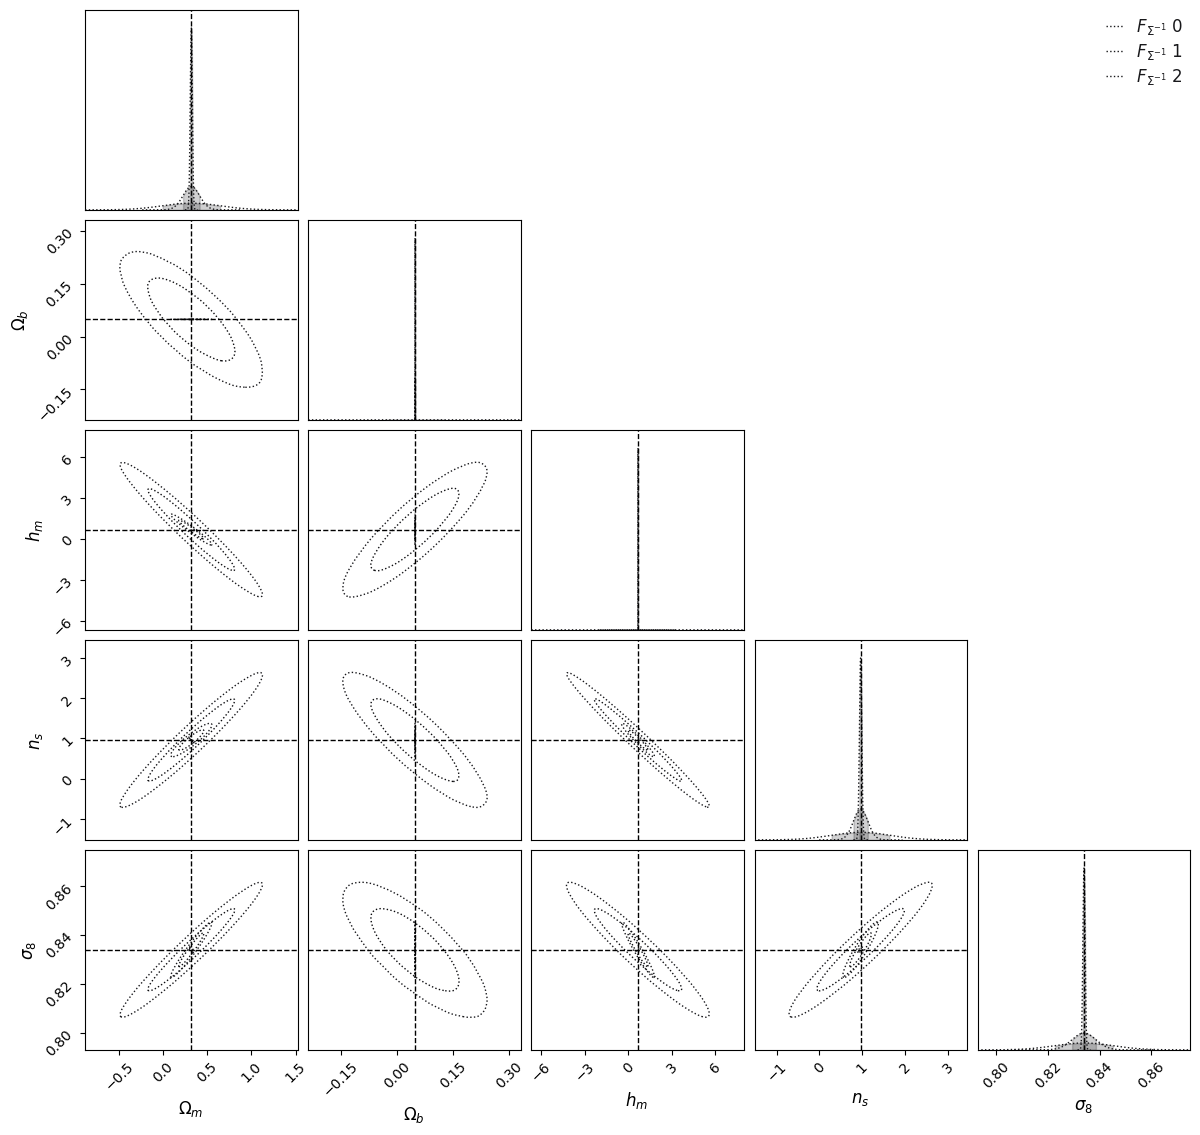

In [5]:
# Compress simulations
# compression_fn = get_compression_fn(config, dataset, results_dir=results_dir)
# X = jax.vmap(compression_fn, in_axes=(0, None))(dataset.fiducial_data, dataset.alpha)

c = ChainConsumer()
for n, Finv in enumerate(Finvs):
    c.add_chain(
        Chain.from_covariance(
            dataset.alpha,
            Finv,
            columns=dataset.parameter_strings,
            name=r"$F_{\Sigma^{-1}}$ " + str(n),
            color="k",
            linestyle=":",
            shade_alpha=0.
        )
    )
c.add_truth(
    Truth(
        location=dict(zip(dataset.parameter_strings, dataset.alpha)), 
        name=r"$\pi^0$"
    )
)
fig = c.plotter.plot()
plt.show()